In [10]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --- user editable parameters ---
SYMBOL       = "btc_usdc"      # change if your file is btc_usdt, etc.
INTERVAL     = "1h"            # 1m / 15m / 1h / 1d ...
START_DATE   = "2025-04-25"            # e.g. "2024-05-03"
END_DATE     = "2025-05-02"            # e.g. "2025-05-03"
ROWS_LIMIT   = None            # e.g. 10000 to display last N rows

# --------------------------------
DATA_DIR = Path("..") / "data"
TA_FILE  = DATA_DIR / f"{SYMBOL}_{INTERVAL}_ta.parquet"

df = pd.read_parquet(TA_FILE)
df['open_dt'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
print(f"Loaded {len(df):,} rows from {TA_FILE}")

if START_DATE:
    start_ts = pd.to_datetime(START_DATE, utc=True)
    df = df[df.open_dt >= start_ts]
if END_DATE:
    end_ts = pd.to_datetime(END_DATE, utc=True)
    df = df[df.open_dt <= end_ts]
if ROWS_LIMIT:
    df = df.tail(ROWS_LIMIT)

print(f"Plotting {len(df):,} rows from {df.open_dt.min()} to {df.open_dt.max()}")

Loaded 8,711 rows from ../data/btc_usdc_1h_ta.parquet
Plotting 169 rows from 2025-04-25 00:00:00+00:00 to 2025-05-02 00:00:00+00:00


## Moyenne Mobile Simple (SMA)
- **Définition** : La SMA est la moyenne arithmétique des prix de clôture d’un actif sur une période donnée (ex. 10, 50, 200 jours). Chaque point est calculé en additionnant les prix de clôture sur la période et en divisant par le nombre de périodes.
- **Utilisation** : Elle sert à lisser les fluctuations des prix pour identifier la tendance générale. Si le prix est au-dessus de la SMA, cela indique souvent une tendance haussière, en dessous une tendance baissière. La période choisie dépend de l’horizon de trading (court, moyen, long terme).
- **Pourquoi** : Simple à calculer et à interpréter, elle aide à détecter les niveaux de support/résistance et les retournements potentiels.

## Moyenne Mobile Exponentielle (EMA)
- **Définition** : L’EMA est une moyenne mobile qui donne plus de poids aux prix récents, ce qui la rend plus réactive que la SMA.
- **Utilisation** : Utilisée pour capter plus rapidement les changements de tendance. Souvent utilisée en croisement (ex. EMA 50 et EMA 200) pour générer des signaux d’achat ou de vente (croisement haussier ou baissier). Elle peut aussi servir de support ou résistance dynamique dans une tendance.
- **Pourquoi** : Moins de retard que la SMA, donc meilleure pour les stratégies de trading à court terme et pour confirmer le momentum avec d’autres indicateurs comme le RSI.

## Indice de Force Relative (RSI)
- **Définition** : Le RSI est un oscillateur de momentum mesurant la vitesse et l’ampleur des variations de prix récentes, exprimé entre 0 et 100.
- **Utilisation** : Il identifie les situations de surachat (RSI > 70) ou de survente (RSI < 30) pour anticiper des retournements. Les divergences entre RSI et prix peuvent signaler des inversions de tendance.
- **Pourquoi** : Permet de détecter des excès dans le mouvement des prix et de prévoir des corrections ou rebonds.

## MACD (Moving Average Convergence Divergence)
- **Définition** : Le MACD est un indicateur de tendance basé sur la différence entre deux EMA (généralement 12 et 26 périodes) et une ligne de signal (EMA de la différence).
- **Utilisation** : Il génère des signaux d’achat/vente par les croisements entre la ligne MACD et la ligne de signal. Les divergences entre MACD et prix indiquent des retournements potentiels. L’histogramme montre la force du momentum.
- **Pourquoi** : Combine la tendance et le momentum pour fournir des signaux clairs d’entrée/sortie sur le marché.

## Bandes de Bollinger
- **Définition** : Les bandes de Bollinger sont constituées d’une moyenne mobile (souvent SMA 20) entourée de deux bandes situées à deux écarts-types au-dessus et en dessous de cette moyenne.
- **Utilisation** : Elles mesurent la volatilité du marché. Lorsque les prix touchent la bande supérieure, l’actif est potentiellement suracheté, et lorsqu’ils touchent la bande inférieure, il est potentiellement survendu. La contraction des bandes annonce souvent une forte volatilité à venir.
- **Pourquoi** : Aide à identifier les phases de consolidation, les ruptures de tendance et les niveaux extrêmes du prix.

## Average True Range (ATR)
- **Définition** : L’ATR est un indicateur de volatilité qui mesure la variation moyenne des prix d’un actif sur une période donnée, en tenant compte des écarts (gaps) entre les sessions. Il est calculé comme la moyenne mobile des “True Range”, où le True Range est le plus grand des écarts suivants : haut du jour - bas du jour, valeur absolue du haut du jour - clôture précédente, valeur absolue du bas du jour - clôture précédente.
- **Utilisation** : L’ATR sert à évaluer la volatilité du marché indépendamment de la direction du prix. Il est couramment utilisé pour ajuster dynamiquement les stop loss et la taille des positions, en fonction de la volatilité actuelle. Une ATR élevée indique une forte volatilité, une ATR basse signale une période calme ou de consolidation.
- **Pourquoi** : Permet une gestion du risque plus adaptée en tenant compte des fluctuations réelles du marché, évitant ainsi des stops trop serrés ou trop larges. Il aide aussi à confirmer des cassures ou des mouvements significatifs en détectant les changements de volatilité[1][2][5][8].

# Idées de stratégies : 
- Acheter quand le cours croise à la haute la SMA 50 en vérifiant que la EMA 21 < SMA 50 puis vendre quand le cours croise à la baise la EMA 21 lorsque EMA 21 > SMA 50

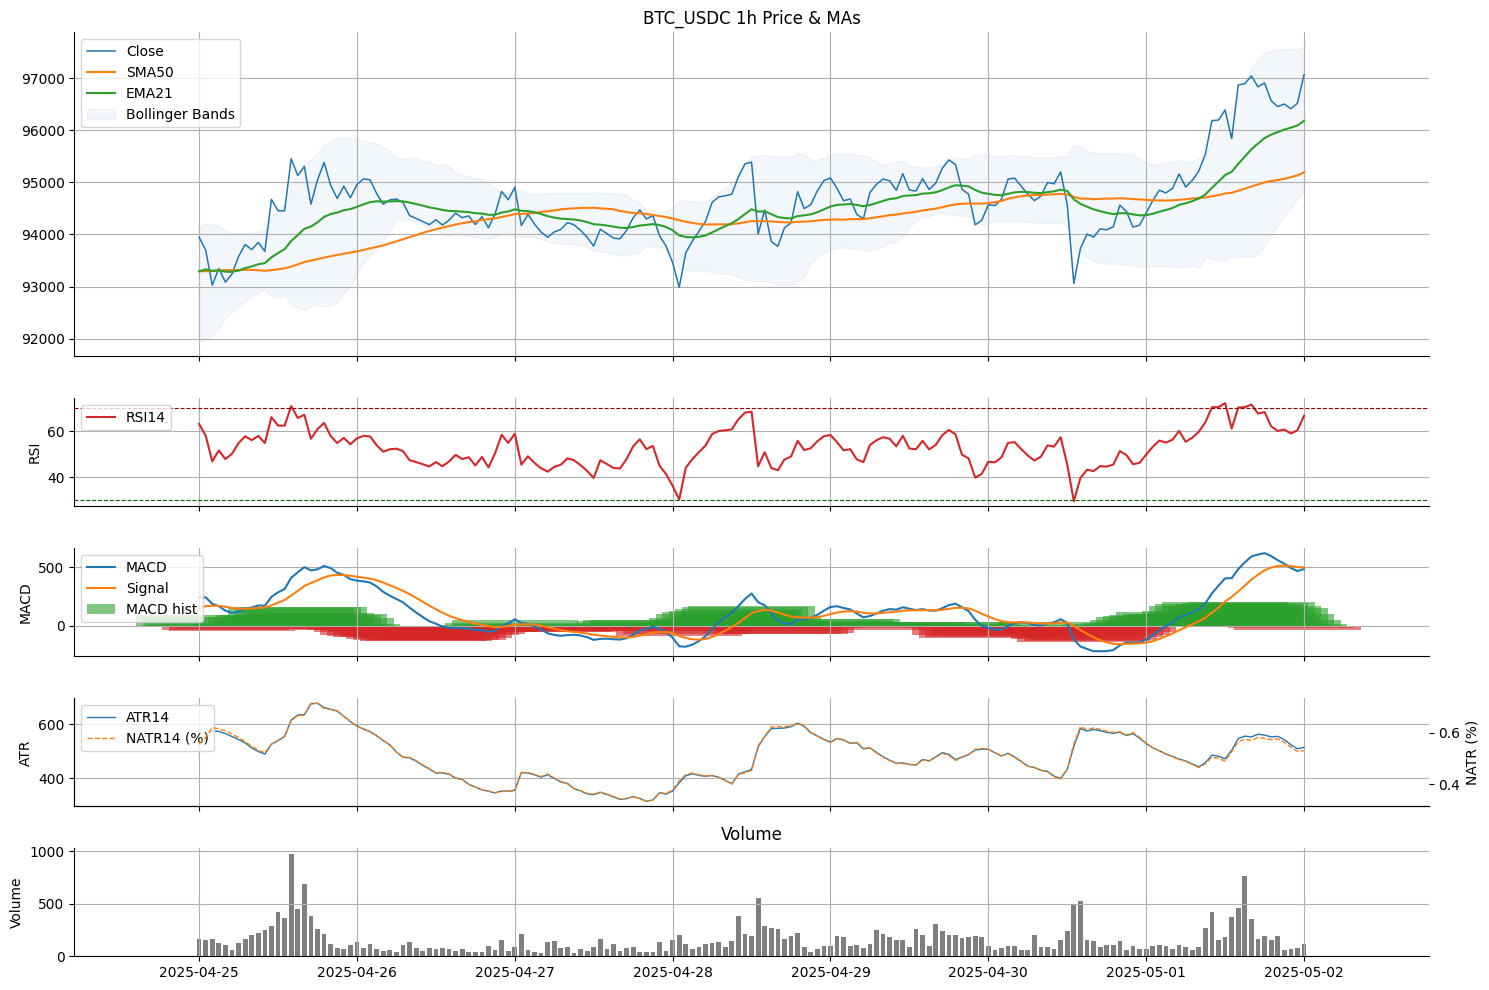

In [12]:
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': (15, 10),
    'axes.grid': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Layout : Price (3) | RSI | MACD | ATR/NATR | Volume
fig, axes = plt.subplots(
    5, 1, sharex=True,
    gridspec_kw={'height_ratios': [3, 1, 1, 1, 1]}
)

# --- Price & Moving Averages + Bollinger ---
ax_price = axes[0]
ax_price.plot(df['open_dt'], df['close'], label='Close', color='#1f77b4', lw=1.1)
if 'sma50' in df.columns:
    ax_price.plot(df['open_dt'], df['sma50'], label='SMA50', color='#ff7f0e')
if 'ema21' in df.columns:
    ax_price.plot(df['open_dt'], df['ema21'], label='EMA21', color='#2ca02c')
if 'BBL_20_2.0' in df.columns:
    ax_price.fill_between(df['open_dt'], df['BBL_20_2.0'], df['BBU_20_2.0'],
                          alpha=0.15, color='#b0c4de', label='Bollinger Bands')
ax_price.set_title(f"{SYMBOL.upper()} {INTERVAL} Price & MAs")
ax_price.legend(loc='upper left')

# --- RSI ---
ax_rsi = axes[1]
if 'rsi14' in df.columns:
    ax_rsi.plot(df['open_dt'], df['rsi14'], color='#d62728', label='RSI14')
    ax_rsi.axhline(70, ls='--', lw=0.8, color='#8b0000')
    ax_rsi.axhline(30, ls='--', lw=0.8, color='#006400')
    ax_rsi.set_ylabel('RSI')
    ax_rsi.legend(loc='upper left')
else:
    ax_rsi.text(0.5, 0.5, 'RSI not in dataset', ha='center', va='center')

# --- MACD ---
ax_macd = axes[2]
if 'MACD_12_26_9' in df.columns:
    colors = ['#2ca02c' if v >= 0 else '#d62728' for v in df['MACDh_12_26_9']]
    ax_macd.bar(df['open_dt'], df['MACDh_12_26_9'], color=colors, alpha=0.6, label='MACD hist')
    ax_macd.plot(df['open_dt'], df['MACD_12_26_9'], color='#1f77b4', label='MACD')
    ax_macd.plot(df['open_dt'], df['MACDs_12_26_9'], color='#ff7f0e', label='Signal')
    ax_macd.set_ylabel('MACD')
    ax_macd.legend(loc='upper left')
else:
    ax_macd.text(0.5, 0.5, 'MACD not in dataset', ha='center', va='center')

# --- ATR (abs) + NATR (%) sur axe secondaire ---
ax_atr = axes[3]
if 'atr14' in df.columns:
    line_atr, = ax_atr.plot(df['open_dt'], df['atr14'], color='#1f77b4', lw=1, label='ATR14')
    ax_atr.set_ylabel('ATR')

    handles = [line_atr]
    labels = ['ATR14']

    if 'natr14' in df.columns:
        ax_natr = ax_atr.twinx()
        line_natr, = ax_natr.plot(df['open_dt'], df['natr14'], color='#ff7f0e', lw=1, ls='--', label='NATR14 (%)')
        ax_natr.set_ylabel('NATR (%)')
        # Ligth grid disable on secondary y to keep plot clean
        ax_natr.grid(False)

        handles.append(line_natr)
        labels.append('NATR14 (%)')

    ax_atr.legend(handles, labels, loc='upper left')
else:
    ax_atr.text(0.5, 0.5, 'ATR not in dataset', ha='center', va='center')

# --- Volume ---
ax_vol = axes[4]
ax_vol.bar(df['open_dt'], df['volume'], width=0.03, color='#7f7f7f')
ax_vol.set_ylabel('Volume')
ax_vol.set_title('Volume')

plt.tight_layout()
plt.show()


